In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset 
from torchvision.io import read_video
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from model_package import VideoChunkDataset, resize_tensor, create_paths_labels, load_model, update_plot, normalize_clip

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Training Path

In [5]:
train_file = [
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_1-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_2-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_3-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_4-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_5-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_6-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_7-sb.txt",
]
val_file = [
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_8-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_9-sb.txt",
]

Data Loaders

In [15]:
trainPaths, trainLabels = create_paths_labels(train_file)
valPaths, valLabels = create_paths_labels(val_file)

# transform = transforms.Compose([
#     transforms.Lambda(lambda x: resize_tensor(x, size=(224, 224)))
# ])

# train_dataset = VideoDataset(trainPaths, trainLabels, transform)
# val_dataset = VideoDataset(valPaths, valLabels, transform)

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

transform = transforms.Compose([
    transforms.Lambda(lambda x: resize_tensor(x, size=(224,224))),
    transforms.Lambda(normalize_clip)
])

train_dataset = VideoChunkDataset(trainPaths, trainLabels, transform=transform)
val_dataset = VideoChunkDataset(valPaths, valLabels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [7]:
from collections import Counter

label_counts = Counter(trainLabels)

# print("Train class distribution (no of clips):")
# for label, count in sorted(label_counts.items()):
#     print(f"Class {label}: {count} samples")

label_counts = Counter([label for _, _, label in train_dataset.samples])

print("Train class distribution (number of 16-frame clips):")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")

Train class distribution (number of 16-frame clips):
Class 0: 876 samples
Class 1: 680 samples
Class 2: 37 samples
Class 3: 143 samples
Class 4: 193 samples


Load Model

In [8]:
model = load_model('/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/model-training/models/i3d_resnet50_v1_kinetics400.yaml', num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Model Training

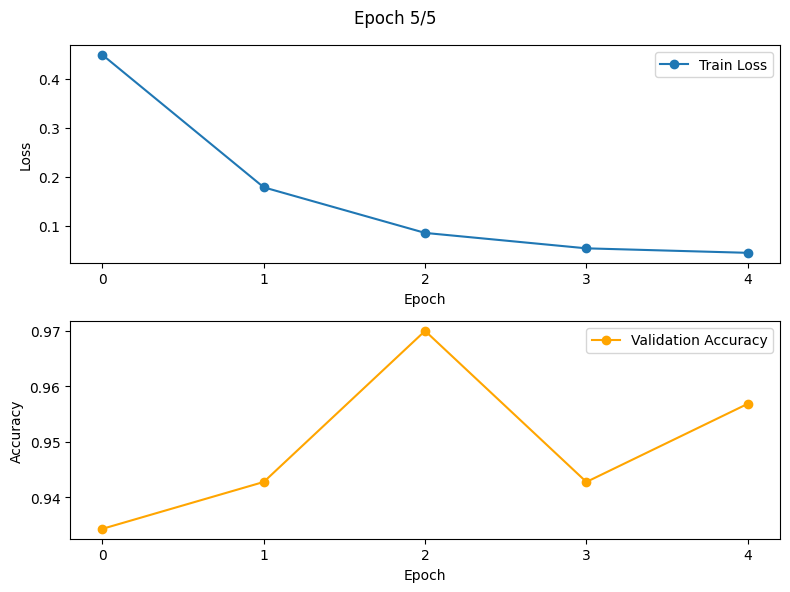

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

num_epochs = 5
train_losses = []
val_accuracies = []

final_preds = []
final_labels = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    start = time.time()

    # Training
    model.train()
    total_loss = 0.0
    batch_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False)

    for videos, labels in batch_bar:
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * videos.size(0)
        batch_bar.set_postfix(loss=loss.item())

    epoch_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    correct, total = 0, 0

    all_preds = []
    all_true = []
    cur_epoch = 0
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validating...", leave=False)
        for videos, labels in val_bar:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if cur_epoch < num_epochs:
                final_preds.extend(preds.cpu().numpy())
                final_labels.extend(labels.cpu().numpy())

            # print("Output shape:", outputs.shape)

            cur_epoch += 1

    accuracy = correct / total
    val_accuracies.append(accuracy)

    # Summary
    print(f"Loss: {epoch_loss:.4f} | Val Acc: {accuracy:.4f} | Time: {time.time() - start:.2f}s")

    # Live plot
    update_plot(epoch, train_losses, val_accuracies, num_epochs)

Confusion Matrix

Inference: 100%|██████████| 267/267 [12:25<00:00,  2.79s/it]


Inference Accuracy: 95.68%


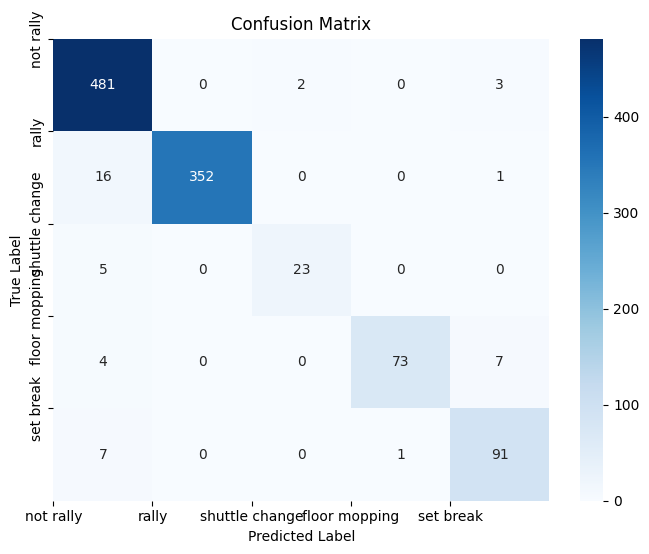

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Compute accuracy
infer_accuracy = accuracy_score(final_labels, final_preds)
print(f"\nInference Accuracy: {infer_accuracy * 100:.2f}%")

class_names = ['not rally', 'rally', 'shuttle change', 'floor mopping', 'set break']

# Confusion matrix
cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.show()

In [11]:
print(len(val_dataset))
print(len(final_preds))

1066
1066


In [14]:
# label_counts = Counter(valLabels)

# print("Inference class distribution (no of clips):")
# for label, count in sorted(label_counts.items()):
#     print(f"Class {label}: {count} samples")

label_counts = Counter([label for _, _, label in val_dataset.samples])

print("Validation class distribution (number of 16-frame clips):")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")

Validation class distribution (number of 16-frame clips):
Class 0: 486 samples
Class 1: 369 samples
Class 2: 28 samples
Class 3: 84 samples
Class 4: 99 samples


Save Model

In [13]:
save_path = '/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/model-training/trained_models/trained_model_6.pth'
torch.save({
    'epoch': epoch,  # Save current epoch to avoid retraining from scratch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,  # Save final training loss
}, save_path)